In [397]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import random

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    sys.path.append(path)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[ 0.          0.         -0.8948761   4.14310649  1.67662534 -2.52247019
 -5.95226168  2.058247    5.4081179   5.07999247 -1.73506583 -1.88107352
  2.52262222  4.14584418 -4.10349508  6.6588195  -1.62058916  4.65734909
  1.30887671  4.36936648  4.20878862  4.00678338 -0.6362134   3.97813033
  4.81264176 -5.44230583 -7.16809095 -6.82895552 -2.76591132 -1.95157331
  0.81554381  6.20616771 -5.60402366 -2.82562403 -7.38814998 -2.10838864
  0.30854864 -7.7615096   5.78647368 -0.49017591 -6.09388483  7.88487016
 -5.63619277 -4.56243152  2.7162409   6.117312   -1.20055118 -5.27023581
  0.          0.          0.        ]


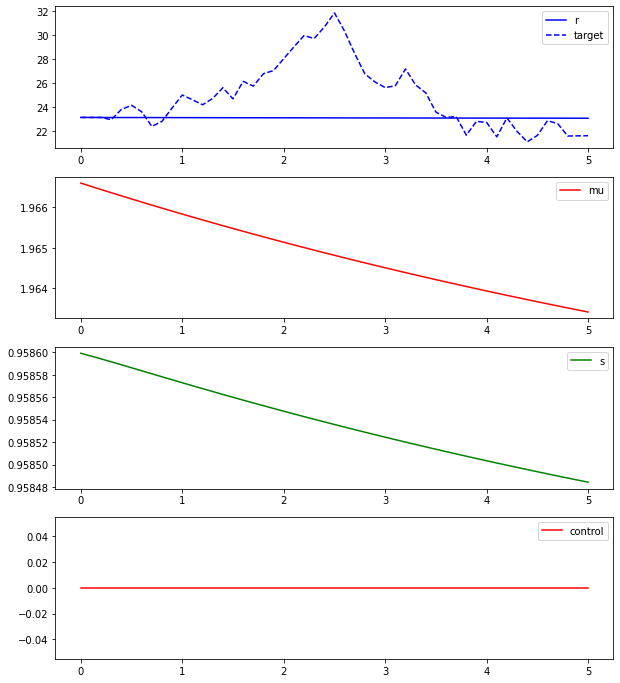

In [418]:
delay = 0
x0 = np.ones(( 3,max(delay,1) ))

tau = 10.
mu_ext = 1.

def r_func(mu):
    x_shift = - 2.
    x_scale = 0.5
    y_shift = 0.1
    y_scale = 0.1
    return y_shift + np.tanh(x_scale * mu + x_shift) * y_scale


def time_integration(x0, T, u, dt):
    time_steps_total = x0.shape[1] + int(T/dt)
        
    x = np.zeros(( 3, time_steps_total ))
    x[:,:x0.shape[1]] = x0[:,:]
        
    for t in range(x0.shape[1], time_steps_total, 1):
        #print(t)
        s_dt = ( - x[2,t-1] + (1. - x[2,t-1]) * x[0,t-1-delay] ) / tau
        x[2,t] = x[2,t-1] + dt * s_dt
        mu_dt = ( x[2,t-1] + mu_ext - x[1,t-1] + u[t-1]) / tau
        x[1,t] = x[1,t-1] + dt * mu_dt
        x[0,t] = r_func(x[1,t]) * 1e3
    
    return x
    
T = 200.
dt = 0.1
    
time = np.arange(0,T+dt, dt)
u0 = np.zeros(time.shape[0])
u0[1980] = 1.
x = time_integration(x0, T, u0, dt)
x0[:,0] = x[:,-1]

T = 5.
time = np.arange(0,T+dt, dt)
u0 = np.zeros(time.shape[0])
x = time_integration(x0, T, u0, dt)
state = x.copy()

u = np.zeros(time.shape[0])
for t in np.arange(2,int(T/dt)-2,1):
    u[t] = random.uniform(-8.,8.)
print(u)
x = time_integration(x0, T, u, dt)
target = np.zeros((time.shape[0]))
target[:] = x[0,:]

plot(time, state, target[:], u0)

Initial cost =  257.21170670371106
1  cost =  149.99815183511905
2  cost =  119.04836635803277
3  cost =  84.90283138733618
4  cost =  71.82128827111686
5  cost =  56.6834199714542
6  cost =  49.28085223520943
7  cost =  40.17677259347545
8  cost =  34.99313121173117
9  cost =  28.703894722334017
10  cost =  24.914099517590632
50  cost =  7.140480482982263
100  cost =  5.197583317195608
Initial cost =  257.21170670371106
1  cost =  150.09413860348013
2  cost =  119.5933484294953
3  cost =  84.71110931578067
4  cost =  70.44697851781692
5  cost =  52.92413979800949
6  cost =  45.64586826358072
7  cost =  35.296775787962346
8  cost =  30.08075678345303
9  cost =  26.627782855288213
10  cost =  24.183856321380624
50  cost =  2.1628505201933153
100  cost =  1.4296701292978293


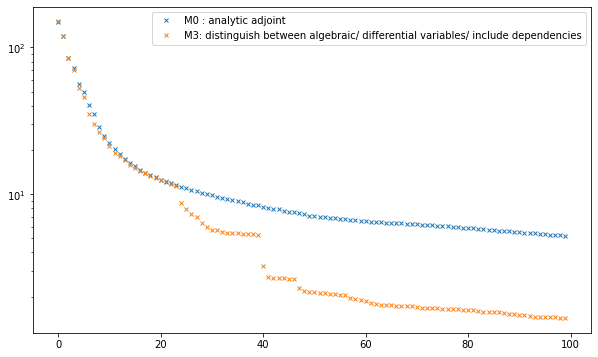

In [423]:
weight = 0.
it = 100

method = 0
u_0, c_0 = iterate(it, state, target, weight, u0, x0, T, method)
x = time_integration(x0, T, u_0, dt)
#plot(time, x, target, u1)

"""
method = 1
u_1, c_1 = iterate(it, state, target, weight, u0, x0, T, method)
x = time_integration(x0, T, u_1, dt)
#plot(time, x, target, u1)

method = 2
u_2, c_2 = iterate(it, state, target, weight, u0, x0, T, method)
x = time_integration(x0, T, u_2, dt)
#plot(time, x, target, u1)
"""

method = 3
u_3, c_3 = iterate(it, state, target, weight, u0, x0, T, method)
x = time_integration(x0, T, u_3, dt)
#plot(time, x, target, u1)

label_ = ['M0 : analytic adjoint',
          'M3: distinguish between algebraic/ differential variables/ include dependencies']
c_array = [c_0, c_3]
fig, ax = plt.subplots(1, figsize=(10,6))
for i in range(len(label_)):
    c_ = c_array[i]
    ax.plot(np.arange(0,len(c_),1), c_, linestyle='', marker='x', markersize=4, label=label_[i])
ax.legend()
ax.set_yscale('log')
plt.show()

In [381]:
alg = [0]
diff = [1,2]
n_var = len(alg) + len(diff)

dep_mat = np.zeros(( n_var, n_var ))
for j in [[0,1], [1,1], [1,2], [2,0], [2,2]]:
    dep_mat[j[0], j[1]] = 1.


def jacobian(st_, t, method):
    if method == 0:
        return jacobian_0(st_, t)
    elif method == 1:
        return jacobian_1(st_, t)
    elif method == 2:
        return jacobian_2(st_, t)
    elif method == 3:
        return jacobian_3(st_, t)

def jacobian_0(state_, t):
    st_ = state_[:,t]
    jacobian = np.zeros(( st_.shape[0], st_.shape[0] ))
    jacobian[0,1] = 1e3 * 0.1 * 0.5 / (np.cosh(0.5*st_[1]-2.))**2
    jacobian[1,1] = -1./tau
    jacobian[1,2] = 1./tau
    jacobian[2,0] = (1.-st_[2])/tau
    jacobian[2,2] = (-1. - st_[0])/tau
    return jacobian

def jacobian_1(st_, t):
    jacobian = np.zeros(( st_.shape[0], st_.shape[0] ))
    n_unknown = n_var + 1
    limit_ = 1e-10
    T_end = ( n_unknown + 1 ) * dt
    u0 = np.zeros(n_unknown+1)
    x0 = np.zeros((n_var,1))
    x0[:,0] = st_[:,max(0,t-2)]
    state1 = time_integration(x0, T_end, u0, dt)

    for j in range(n_var):
        A_ = np.zeros(( n_unknown, n_unknown ))
        x_ = np.zeros(( n_unknown ))

        for t in range(n_unknown):
            for k in range(n_var):
                A_[t,k] = state1[k,t]
            A_[t,-1] = 1.
            x_[t] = ( state1[j,t+1] - state1[j,t] ) / dt

        if np.amax(x_) - np.amin(x_) < limit_:
            jac[j,:] = 0.
        else:
            sol = np.linalg.solve(A_, x_)
            for k in range(n_var):
                jacobian[j,k] = sol[k]
    
    return jacobian

def jacobian_2(st_, t):
    jacobian = np.zeros(( st_.shape[0], st_.shape[0] ))
    
    n_unknown = n_var + 1
    limit_ = 1e-10
    T_end = ( n_unknown + 1 ) * dt
    u0 = np.zeros(n_unknown+1)
    x0 = np.zeros((n_var,1))
    x0[:,0] = st_[:,max(0,t-2)]
    state1 = time_integration(x0, T_end, u0, dt)
    
    for j in range(n_var):
        if j in alg:

            n_unknown = n_var + 1
            A_ = np.zeros(( n_unknown, n_unknown ))
            x_ = np.zeros(( n_unknown ))

            for t in range(n_unknown):
                for k in range(n_var):
                    A_[t,k] = state1[k,t]
                A_[t,-1] = 1.
                x_[t] = ( state1[j,t+1] - state1[j,t] ) / dt

            if np.amax(x_) - np.amin(x_) < limit_:
                jac[j,:] = 0.
            else:
                sol = np.linalg.solve(A_, x_)
                for k in range(3):
                    jacobian[j,k] = sol[k]
        
        elif j in diff:
            n_unknown = int(sum(dep_mat[j,:]) + 1)
            A_ = np.zeros(( n_unknown, n_unknown ))
            x_ = np.zeros(( n_unknown ))
            
            for t in range(n_unknown):
                ind_mat = 0
                for k in range(n_unknown - 1):
                    while dep_mat[j,ind_mat] == 0.:
                        ind_mat += 1
                    A_[t,k] = state1[ind_mat,t]
                    ind_mat += 1
                A_[t,-1] = 1.
                x_[t] = ( state1[j,t+1] - state1[j,t] ) / dt

            if np.amax(x_) - np.amin(x_) < limit_:
                jac[j,:] = 0.
            else:
                sol = np.linalg.solve(A_, x_)
                ind_mat = 0
                for k in range(n_unknown - 1):
                    while dep_mat[j,ind_mat] == 0.:
                        ind_mat += 1
                    jacobian[j,ind_mat] = sol[k]
                    ind_mat += 1
    
    return jacobian

def jacobian_3(st_, t):
    jacobian = np.zeros(( st_.shape[0], st_.shape[0] ))
    
    n_unknown = n_var + 1
    limit_ = 1e-10
    T_end = ( n_unknown + 1 ) * dt
    u0 = np.zeros(n_unknown+1)
    x0 = np.zeros((n_var,1))
    x0[:,0] = st_[:,max(0,t-2)]
    state1 = time_integration(x0, T_end, u0, dt)
    
    for j in range(n_var):
        if j in alg:
            n_unknown = int(sum(dep_mat[j,:]) + 1)
            A_ = np.zeros(( n_unknown, n_unknown ))
            x_ = np.zeros(( n_unknown ))
            
            for t in range(n_unknown):
                ind_mat = 0
                for k in range(n_unknown - 1):
                    while dep_mat[j,ind_mat] == 0.:
                        ind_mat += 1
                    A_[t,k] = state1[ind_mat,t]
                    ind_mat += 1
                A_[t,-1] = 1.
                x_[t] = state1[j,t]

            if np.amax(x_) - np.amin(x_) < limit_:
                jac[j,:] = 0.
            else:
                sol = np.linalg.solve(A_, x_)
                ind_mat = 0
                for k in range(n_unknown - 1):
                    while dep_mat[j,ind_mat] == 0.:
                        ind_mat += 1
                    jacobian[j,ind_mat] = sol[k]
                    ind_mat += 1
        
        elif j in diff:
            n_unknown = int(sum(dep_mat[j,:]) + 1)
            A_ = np.zeros(( n_unknown, n_unknown ))
            x_ = np.zeros(( n_unknown ))
            
            for t in range(n_unknown):
                ind_mat = 0
                for k in range(n_unknown - 1):
                    while dep_mat[j,ind_mat] == 0.:
                        ind_mat += 1
                    A_[t,k] = state1[ind_mat,t]
                    ind_mat += 1
                A_[t,-1] = 1.
                x_[t] = ( state1[j,t+1] - state1[j,t] ) / dt

            if np.amax(x_) - np.amin(x_) < limit_:
                jac[j,:] = 0.
            else:
                sol = np.linalg.solve(A_, x_)
                ind_mat = 0
                for k in range(n_unknown - 1):
                    while dep_mat[j,ind_mat] == 0.:
                        ind_mat += 1
                    jacobian[j,ind_mat] = sol[k]
                    ind_mat += 1
    
    return jacobian

In [421]:
def adjoint(st_, fp, method):
    if method == 0:
        return adjoint_0(st_, fp, method)
    elif method in [1,2,3]:
        return adjoint_1(st_, fp, method)

def adjoint_0(st_, fp, method):
    adjoint = np.zeros((st_.shape))
    #adjoint[0,-1] = fp[-1]
    
    t = adjoint.shape[1]-1
    jac_t0 = jacobian(st_, t, method)
    adjoint[0,t] = fp[t]
    adjoint[1,t] = dt * ( adjoint[0,t] * jac_t0[0,1] )
    adjoint[2,t] = dt * ( adjoint[1,t] * jac_t0[1,1] )
    
    for t in range(adjoint.shape[1]-2, 0, -1):
        #print(t)
        jac_t1 = jacobian(st_, t+1, method)
        jac_t0 = jacobian(st_, t, method)
        adjoint[0,t] = fp[t]
        for k1 in range(n_var):
            adjoint[0,t] += adjoint[k1,t+1] * jac_t1[k1,0]
        for k in diff:
            der = 0.
            for k1 in range(n_var):
                der += adjoint[k1,t] * jac_t0[k1,k]
            adjoint[k,t] = adjoint[k,t+1] + dt * der
        
    return adjoint

def adjoint_1(st_, fp, method):
    adjoint = np.zeros((st_.shape))
    #adjoint[0,-1] = fp[-1]
    
    t = adjoint.shape[1]-1
    jac_t0 = jacobian(st_, t, method)
        
    for k in alg:
        if k == 0:
            adjoint[k,t] += fp[t]

    for k in diff:
        der = 0.
        for k1 in range(n_var):
            der += adjoint[k1,t] * jac_t0[k1,k]
        adjoint[k,t] = dt * der
    
    for t in range(adjoint.shape[1]-2, 0, -1):
        jac_t1 = jacobian(st_, t+1, method)
        jac_t0 = jacobian(st_, t, method)
        
        for k in alg:
            if k == 0:
                adjoint[k,t] += fp[t]
            for k1 in range(n_var):
                adjoint[k,t] += adjoint[k1,t+1] * jac_t1[k1,k]
                
        for k in diff:
            der = 0.
            for k1 in range(n_var):
                der += adjoint[k1,t] * jac_t0[k1,k]
            adjoint[k,t] = adjoint[k,t+1] + dt * der
        
    return adjoint

In [333]:
    
def fp(state, target):
    return (state[0,:] - target[:])

def fu(w, u):
    return w*u
    
def grad(adjoint, fu):
    grad = np.zeros((adjoint.shape[1]))
    for t in range(grad.shape[0]-1):
        grad[t] = fu[t] + adjoint[1,t+1] / tau
    return grad

def cost(state, target, w, u):
    cost = 0.
    for t in range(state.shape[1]):
        cost += 0.5 * ( state[0,t] - target[t] )**2 + 0.5 * w * u[t]**2
    return cost

def bisection(w, u0, d0, target, x0, T):
    c0 = cost(time_integration(x0, T, u0, dt), target, w, u0)
    s = 10.
    c1 = cost(time_integration(x0, T, u0+s*d0, dt), target, w, u0+s*d0)
    c2 = cost(time_integration(x0, T, u0+0.9*s*d0, dt), target, w, u0+s*d0)
    while c2 < c1:
        s *= 0.9
        c1 = cost(time_integration(x0, T, u0+s*d0, dt), target, w, u0+s*d0)
        c2 = cost(time_integration(x0, T, u0+0.9*s*d0, dt), target, w, u0+s*d0)
        #print("step, cost = ", s, c1, c2)
        if s < 1e-6:
            print("step size limit reached")
            return 0.
        
    return s

def iterate(max_it, state, target, w, u0, x0, T, method):
    print("Initial cost = ", cost(time_integration(x0, T, u0, dt), target, w, u0))
    cost_list = []
    u1 = u0.copy()
    for i in range(max_it):
        fp_ = fp(state, target)
        adj = adjoint(state,fp_, method)
        direction = -grad(adj, fu(w, u0))
        step = bisection(w, u0, direction, target, x0, T)
        u1 = u0 + step * direction
        state = time_integration(x0, T, u1, dt)
        cost_list.append(cost(time_integration(x0, T, u1, dt), target, w, u1))
        if i < 10 or (i+1)%50 == 0:
            print(i+1, " cost = ", cost_list[-1])
        u0 = u1.copy()
        x = time_integration(x0, T, u1, dt)
    return u1, cost_list

In [208]:
def plot(time, state, target, u):
    fig, ax = plt.subplots(4,1, figsize=(10,12))
    ax[0].plot(time, state[0,:], color='blue', label='r')
    ax[0].plot(time, target[:], color='blue', linestyle='--', label='target')
    ax[1].plot(time, state[1,:], color='red', label='mu')
    ax[2].plot(time, state[2,:], color='green', label='s')
    ax[3].plot(time, u[:], color='red', label='control')
    for i in range(4):
        ax[i].legend()
    plt.show()


In [97]:
x_init = x[:,-1:]
T = 10*dt
state1 = time_integration(x_init, T, dt)

A_num = np.zeros(( 3, 3 ))
A_delay = np.zeros(( 3,3 ))
C_num = np.zeros(( 3 ))

A_ = np.zeros(( 3, 3 ))
x_ = np.zeros(( 3 ))

for t in range(3):
    A_[t,0] = state1[1,t]
    A_[t,1] = state1[2,t]
    A_[t,2] = 1.
    x_[t] = ( state1[1,t+1] - state1[1,t] ) / dt
    
sol = np.linalg.solve(A_, x_)
print(sol)
A_num[1,1] = sol[0]
A_num[1,2] = sol[1]
C_num[1] = sol[2]

A_ = np.zeros(( 3, 3 ))
x_ = np.zeros(( 3 ))

for t in range(3):
    A_[t,0] = state1[0,t-delay]
    A_[t,1] = state1[2,t]
    A_[t,2] = 1.
    x_[t] = ( state1[2,t+1] - state1[2,t] ) / dt
    
sol = np.linalg.solve(A_, x_)
print(sol)
A_delay[2,0] = sol[0]
A_num[2,2] = sol[1]
C_num[2] = sol[2]

A_ = np.zeros(( 2,2 ))
x_ = np.zeros(( 2 ))

for t in range(2):
    A_[t,0] = state1[1,t]
    A_[t,1] = 1.
    x_[t] = - state1[0,t]
    
sol = np.linalg.solve(A_, x_)
print(sol)
A_num[0,1] = sol[0]
C_num[0] = sol[1]

[-0.09996061  0.09797849  0.10186009]
[ 1.23067778e-04 -1.62408443e-01  1.52810713e-01]
[-18.23746416  12.88000069]


[[-1.26942337e+01 -1.25075932e+01 -1.23201600e+01 -1.21319849e+01
  -1.19431173e+01]
 [ 1.01860087e-02  2.04199190e-02  3.06972899e-02  4.10153421e-02
   5.13713626e-02]
 [ 1.52810713e-02  3.01577399e-02  4.47950958e-02  5.91970354e-02
   7.33673912e-02]]


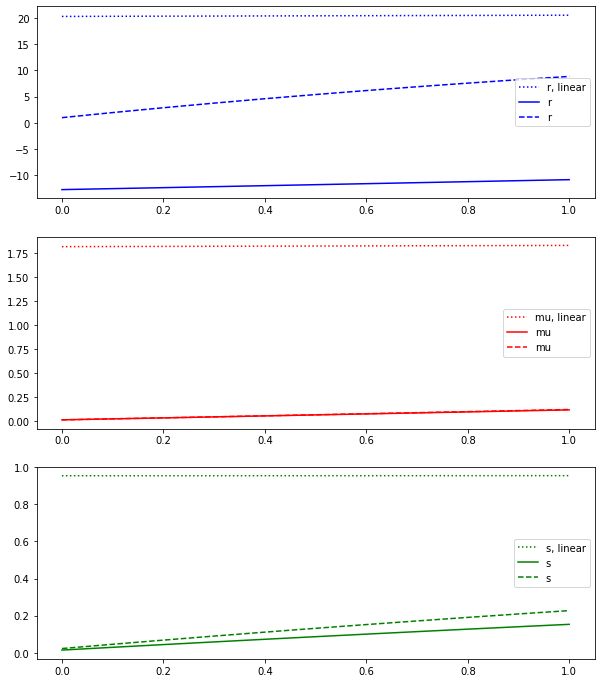

In [108]:
time = np.arange(0,T+dt, dt)

x_lin = lin_approx(x_init, A_num, A_delay, C_num, T)
x_lin2 = lin_approx2(x_init, A_num2, A_delay2, C_num2, T)

print(x_lin[:,:5])

fig, ax = plt.subplots(3,1, figsize=(10,12))
ax[0].plot(time, state1[0,:], color='blue', linestyle=':', label='r, linear')
ax[0].plot(time, x_lin[0,:], color='blue', label='r')
ax[0].plot(time, x_lin2[0,], color='blue', linestyle='--', label='r')
ax[1].plot(time, state1[1,:], color='red', linestyle=':',  label='mu, linear')
ax[1].plot(time, x_lin[1,:], color='red', label='mu')
ax[1].plot(time, x_lin2[1,:], color='red', linestyle='--', label='mu')
ax[2].plot(time, state1[2,:], color='green', linestyle=':',  label='s, linear')
ax[2].plot(time, x_lin[2,:], color='green', label='s')
ax[2].plot(time, x_lin2[2,:], color='green', linestyle='--', label='s')

for j in range(3):
    ax[j].legend()
plt.show()

In [105]:
def lin_approx(x0, A, A_delay, C, T):
    time_steps_total = x0.shape[1] + int(T/dt)
    x = np.zeros((3,time_steps_total))
    
    x[:,:delay] = x0
    
    for t in range(delay,time_steps_total):
    
        res = np.matmul(A, x[:,t-1]) + np.matmul(A_delay, x[:,t-1-delay]) + C[:]
        x[1,t] = x[1,t-1] + dt*res[1]
        x[2,t] = x[2,t-1] + dt*res[2]
        
        res = np.matmul(A, x[:,t]) + np.matmul(A_delay, x[:,t-delay]) + C[:]
        x[0,t] = - res[0]
    
    return x

In [106]:
A_num2 = np.zeros(( 3, 3 ))
C_num2 = np.zeros(( 3 ))

n_unknown = 4

for j in range(3):
    A_ = np.zeros(( n_unknown, n_unknown ))
    x_ = np.zeros(( n_unknown ))

    for t in range(n_unknown):
        A_[t,0] = state1[0,t]
        A_[t,1] = state1[1,t]
        A_[t,2] = state1[2,t]
        A_[t,-1] = 1.
        x_[t] = ( state1[j,t+1] - state1[j,t] ) / dt

    print("x_ = ", x_)
    sol = np.linalg.solve(A_, x_)
    print(sol)
    for k in range(3):
        A_num2[j,k] = sol[k]
    C_num2[j] = sol[-1]

x_ =  [0.24491096 0.2428236  0.24075135 0.23869416]
[ -0.22393678   3.01356521 -11.34990368  10.12089943]
x_ =  [0.013429   0.01330038 0.01317297 0.01304678]
[-1.91631050e-06 -9.98992809e-02  9.73596889e-02  1.02376995e-01]
x_ =  [0.00057254 0.00056625 0.00056004 0.00055391]
[-1.84235234e-04  9.83513758e-03 -2.61641175e-01  2.35703006e-01]


In [107]:
def lin_approx2(x0, A, A_delay, C, T):
    time_steps_total = x0.shape[1] + int(T/dt)
    x = np.zeros((3,time_steps_total))
    
    x[:,:delay] = x0
    
    for t in range(delay,time_steps_total):
    
        res = np.matmul(A, x[:,t-1]) + np.matmul(A_delay, x[:,t-delay]) + C[:]
        
        j = 0        
        
        for j in range(3):
            x[j,t] = x[j,t-1] + dt*res[j]
    
    return x